# 2ème Partie : Algorithme de Dijkstra

### Présentation de l'algorithme

Publié en 1959 par l'informaticien néerlandais Edsger Dijkstra dont il porte le nom, Il s'agit d'un algorithme permettant de résoudre le problème du plus long chemin entre deux sommets d'un graphe orienté ou non avec un poids lié aux arêtes positif ou nul. 

L'algorithme de dijsktra implémenté permet de trouver le trajet optimal vers tout les sommets du graphe en partant du sommet de départ 's'.

In [60]:
def dijkstra(graphe, s) :
    infini = 100000
    sommet_visite = {s : [0,[s]]}
    sommet_non_visite = {i: [infini,''] for i in graphe if i!=s}
    for suivant in graphe[s]:
        sommet_non_visite[suivant] = [graphe[s][suivant], s]
    while sommet_non_visite and any(sommet_non_visite[i][0] < infini for i in sommet_non_visite):
        a= min(sommet_non_visite, key = sommet_non_visite.get)
        longueur_a, precedent_a = sommet_non_visite[a]
        for k in graphe[a]:
            if k in sommet_non_visite:
                d = longueur_a + graphe[a][k]
            if d < sommet_non_visite[k][0]:
                sommet_non_visite[k]=[d,a]
        sommet_visite[a] = [longueur_a, sommet_visite[precedent_a][1] + [a]]
        del sommet_non_visite[a]
    return sommet_visite

la complexité de l'algorithme est en O((nombre d'arêtes + nbr de sommets)*log(nombre de sommets))

La fonction dijkstrav2 nous permet de récuperer l'itinéraire qui a été trouvé par l'algorithme précédent

In [61]:
def dijkstrav2 (graph, s,a) :
    return dijkstra(graph, s) [a]

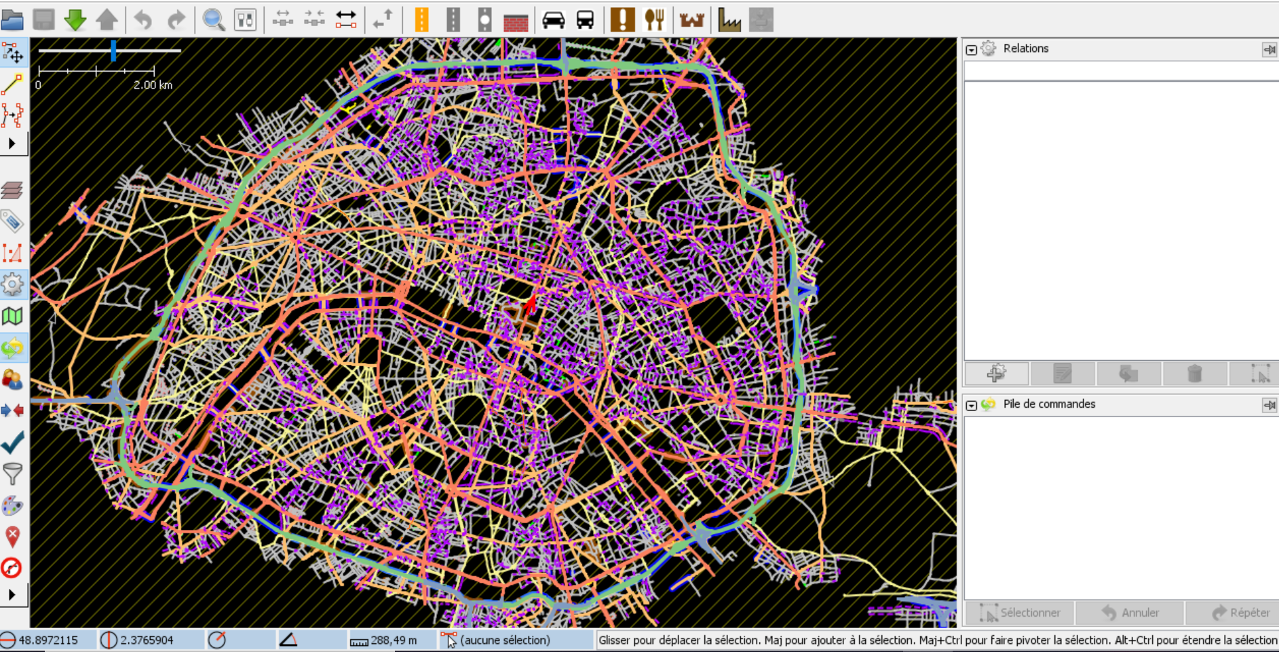

In [62]:
from IPython import display
display.Image("/Users/abdel/Desktop/carte par.png")


extraction de données OSM (Open Street Map) via JOSM, on filtre les données inutiles de la carte puis on gtélécharge la carte en format txt et via les fonctions ci dessous on crée un graphe sous forme de dictionnaire à partir des données.

In [63]:
def numeros(ligne):
    a=ligne.replace("'",'"')
    for k in range(len(a)):
        if a[k]=='"':
            j=k+1
            while a[j]!='"':
                j+=1
            return a[k+1:j]

In [64]:
def lat(ligne):
    a=ligne.replace("'",'"')
    for k in range(len(a)):
        if a[k:k+4]=='lat=':
            return(numeros(ligne[k:]))
def long(ligne):
    a=ligne.replace("'",'"')
    for i in range(len(a)):
        if a[i:i+4]=='lon=':
            return(numeros(ligne[i:]))


In [65]:
def vitesse(ligne):
    try:
        a=ligne.replace("'",'"')
        if 'k="maxspeed"' in a:
            v=''
            for i in a:
                try:
                    f=int(i)
                    v+=i
                except:
                    pass
            return int(v)
        else:
            return None
    except:
        pass
    return None


la fonction distance permetv de calculer la distance entre deux points à partir de leurs coordonnées GPS

In [66]:
from math import *
import numpy as np
def distance (a,b):
    return np.arccos(np.sin(radians(float(a['latitude'])))*np.sin(radians(float(b['latitude'])))+np.cos(radians(float(a['latitude'])))*np.cos(radians(float(b['latitude'])))*np.cos(radians(float(a['longitude'])-float(b['longitude']))))*6371


In [67]:
def dist(listeofnode):
    diste=0
    a=listeofnode[0]
    b=listeofnode[0]
    for i in listeofnode:
        a,b=b,i
        diste+=distance(graph_node[a],graph_node[b])
    return(diste)

In [68]:
def dictionnaire_way(file):
    f= open(file,"r",encoding="utf8")
    L=[i for i in f.readlines()]
    G={}
    for i in range (len(L)):
        Nd=[]
        if L[i][0:10]=="  <way id=":
            G[numeros(L[i])]={}
            k=i+1
            while L[k][0:9]!="  </way>":
                if vitesse(L[k])!=None:
                    a=vitesse(L[k])
                    vmax=vitesse(L[k])
                    break
                else:
                    a=None
                    k+=1
            if a==None:
                vmax=50
            j=i+1
            while L[j][5:7]=='nd':
                Nd.append(numeros(L[j]))
                j+=1
            G.update({numeros(L[i]):{i:None for i in Nd}})
            G[numeros(L[i])].update({'vmax':vmax})
    f.close()
    return G

In [69]:
def dictionnaire_node(file):
    f= open(file,"r",encoding="utf8")
    L=[i for i in f.readlines()]
    G={}
    for i in range (len(L)):
        Nd=[]
        if L[i][0:10]=="  <node id":
            G[numeros(L[i])]={'latitude':lat(L[i]),'longitude':long(L[i])}
    f.close()
    return G

La fonction dico_final permet de créer la map utile pour calculer les trajets des pietons. 

In [70]:
def dico_final(dicoway,diconode):
    dicof={}
    for i in dicoway:
        for j in dicoway[i]:
            if j not in dicof:
                dicof[j]={}
            for k in dicoway[i]:
                if k not in dicof[j]:
                    try:
                        dicof[j][k]=distance(diconode[j],diconode[k])
                    except:
                        pass

    return dicof


dicosens ajoute la contrainte des sens interdits pour pouvoir calculer les itinéraires des automobilistes.

In [71]:
def dicosens (dicoway, diconode): #Prise en compte des sens interdits dans le dictionnaire final
    dicof={}
    for i in dicoway:
        L=[]
        for j in dicoway[i]:
            if j!='vmax' and j!='sensint':
                L.append(j)
        if dicoway[i]['sensint']:
            for k in range(len(L)) :
                if L[k] not in dicof:
                    dicof[L[k]]={}
                for h in L[k:]:
                    try:
                        dicof[L[k]][h]=distance(diconode[L[k]],diconode[h])/(dicoway[i]['vmax'])
                    except:
                        pass
        else:
            for x in dicoway[i]:
                if x not in dicof:
                    dicof[x]={}
                for y in dicoway[i]:
                    if x!='vmax' and x!='sensint' and y!='vmax' and y!='sensint':
                        try:
                            dicof[x][y]=distance(diconode[x],diconode[y])/(dicoway[i]['vmax'])
                        except:
                            pass
    return dicof


la fonction essence permet de répertorier les stations essence pour pouvoir ajouter la contrainte du carburant aux trajets

In [72]:
def essence(file,diconode):
    F=[]
    N=[]
    Num=[]
    f= open(file,"r",encoding="utf8")
    L=[i for i in f.readlines()]
    G={}
    for i in range (len(L)):
        if L[i][0:10]=="  <node id":
            nd=numeros(L[i])
            j=i+1
            while '</node>' not in L[j]:
                if "v='fuel'" in L[j]:
                    latitude=lat(L[i])
                    longitude=long(L[i])
                    Num.append(nd)
                    N.append([latitude,longitude])
                    break
                else:
                    j+=1
    for i in N:
        a=''
        m=100000000000000
        for j in diconode:
            if j not in Num:
                b=np.arccos(np.sin(radians(float(diconode[j]['latitude'])))*np.sin(radians(float(i[0])))+np.cos(radians(float(diconode[j]['latitude'])))*np.cos(radians(float(i[0])))*np.cos(radians(float(diconode[j]['longitude'])-float(i[1]))))*6371
                if b<m:
                    m=b
                    a=j
        F.append(a)
    return F

In [73]:
graph_way=dictionnaire_way('C:\\Users\\elkac\\OneDrive\\Bureau\\Projet\\mapfinale.txt')
graph_node=dictionnaire_node('C:\\Users\\elkac\\OneDrive\\Bureau\\Projet\\mapfinale.txt')
graphv=dico_finalvit(graph_way,graph_node)
stationservice=essence('C:\\Users\\elkac\\OneDrive\\Bureau\\Projet\\mapfinale.txt',graph_node)
graph_node=dictionnaire_node('C:\\Users\\elkac\\OneDrive\\Bureau\\Projet\\petit_test.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\elkac\\OneDrive\\Bureau\\Projet\\mapfinale.txt'

la fonction pieton, permet de calculer à l'aide de l'algorithme de Dijkstra le trajet optimal pour un piéton et affiche les informations relatives aux trajets (distance, temps) et envoie le lien google maps qui correspond au trajet

In [74]:
def pieton(graph,s,a):
    trajet=dijkstrav2(graph,s,a)
    L=''
    distance=trajet[0]
    for i in trajet[1]:
        L=L+'/'+graph_node[i]['latitude']+','+graph_node[i]['longitude']
    print('temps='+str(int(distance*60/4.5))+"min"+str(int((distance*3600%4.5)))+"sec")
    return('https'+':'+'//www.google.fr/maps/dir'+L)

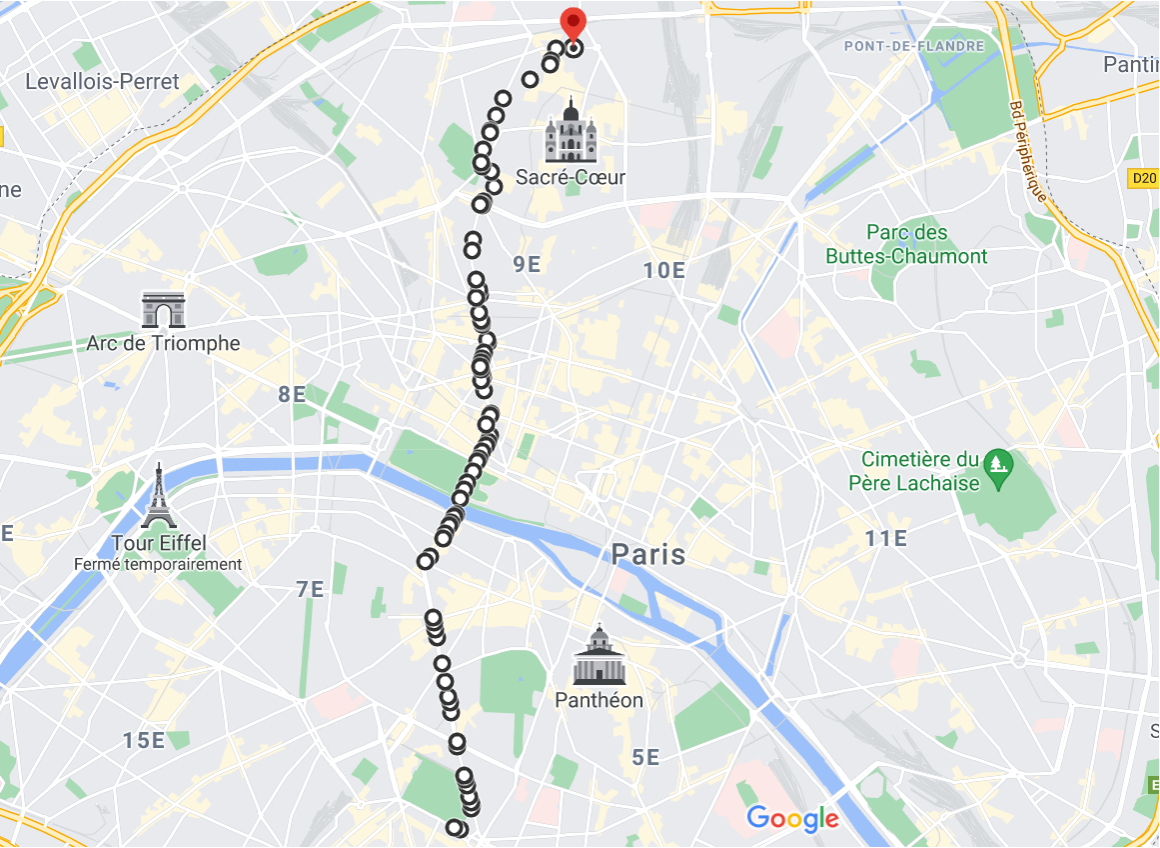

In [75]:
from IPython import display
display.Image("/Users/abdel/Desktop/S8.png")

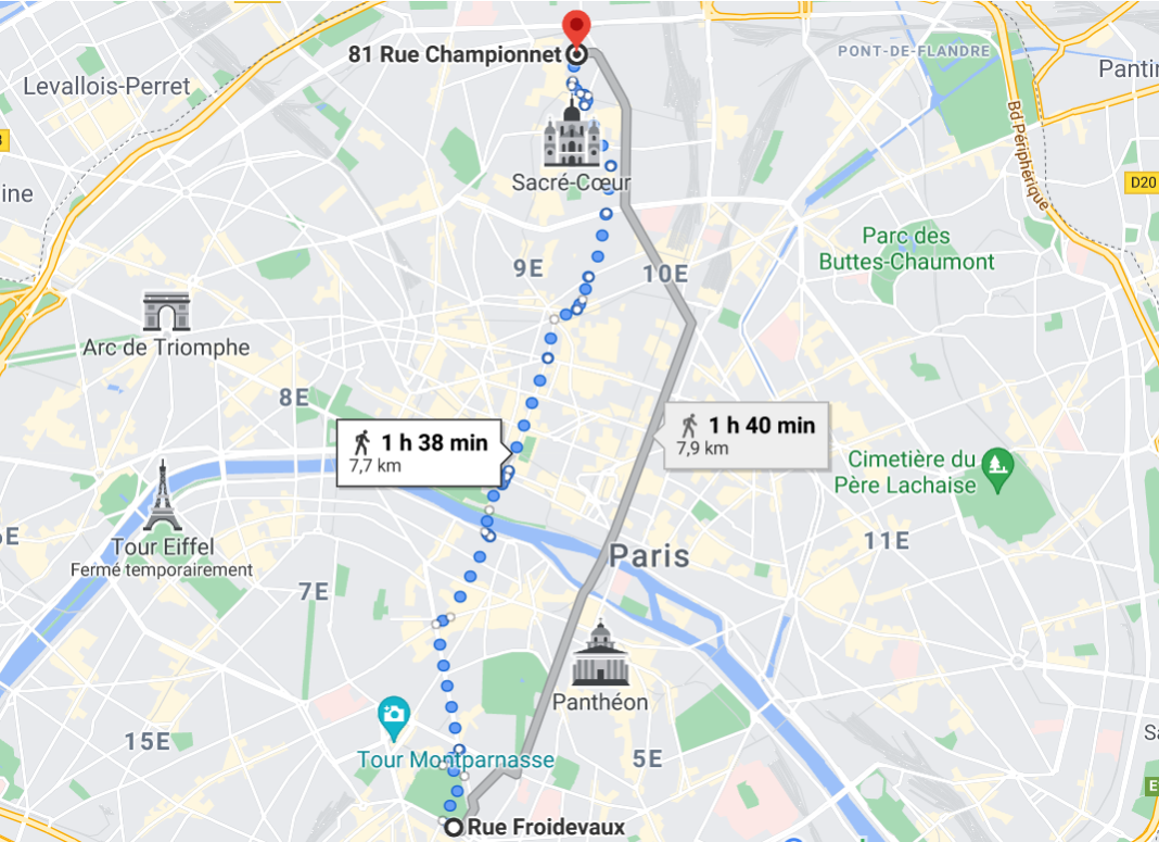

In [76]:
from IPython import display
display.Image("/Users/abdel/Desktop/S9.png")

La fonction voiture permet de calculer les oitinéraires en prenant en compte les diverses contraintes (sens interdits, essence et limitations de vitesse) 

In [77]:
def voiture(s,a,conso,reservoire):
    resultat=dijkstrav2(graphv,s,a)
    d=dist(resultat[1])
    station=0
    max = reservoire/conso
    if conso*d > reservoire :
        trajet1=resultat[1]
        indice=-1
        for i in range(len(resultat[1])):
            if resultat[1][i] in stationservice and dist(resultat[1][0:i+1])<=max:
                indice=i
                break
            else:
                for x in stationservice:
                    h=dijkstrav2(graphv,resultat[1][i],x)
                    dh=(dist(h[1])+dist(resultat[1][0:i+1]))
                    if max > dh :
                        max=dh
                        trajet1=resultat[1][0:i+1]
                        indice=i
                        station=x
        if indice==-1:
            return "essance insufisant"
        g=dijkstrav2(graphv,station,a)
        resultat=[g[0]+trajet1[0],trajet1[1]+g[1]]
    L=''
    d=dist(resultat[1])
    essence=(d-max)*conso
    if d-max>=0:
        print('faire'+str(essence)+"litre d'essence")
    for i in resultat[1]:
        L=L+'/'+graph_node[i]['latitude']+','+graph_node[i]['longitude']
    print('temps='+str(resultat[0]*60))
    print('distance='+str(d))
    return('https'+':'+'//www.google.fr/maps/dir'+L)


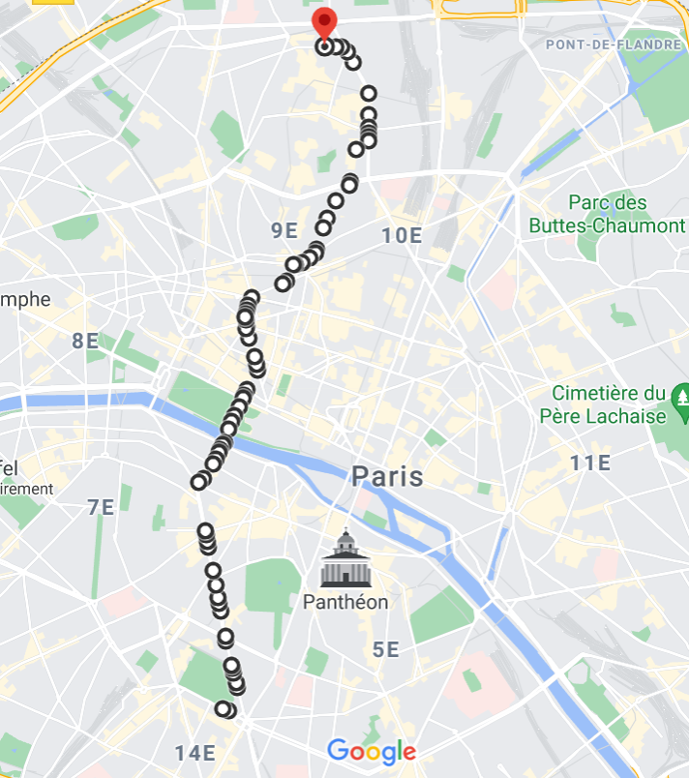

In [78]:
from IPython import display
display.Image("/Users/abdel/Desktop/S10a.png")

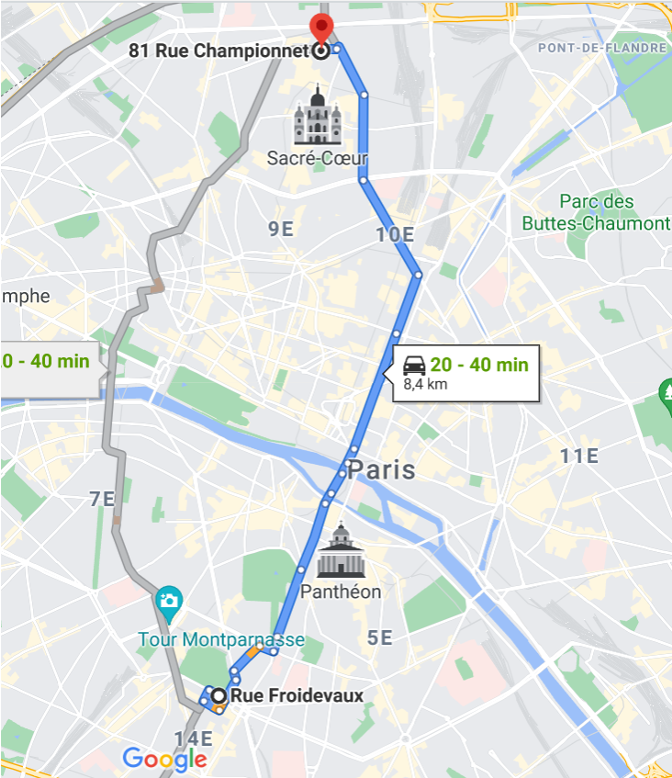

In [79]:
from IPython import display
display.Image("/Users/abdel/Desktop/S10b.png")

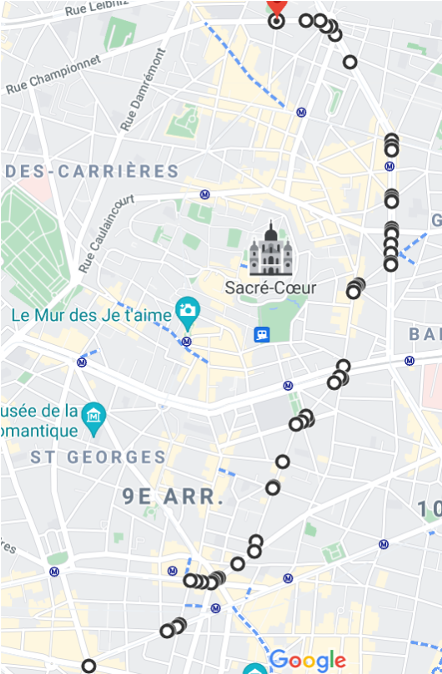

In [80]:
from IPython import display
display.Image("/Users/abdel/Desktop/S11a.png")

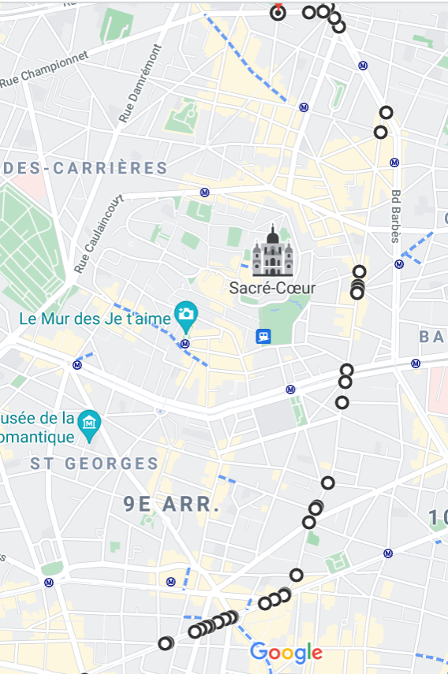

In [81]:
from IPython import display
display.Image("/Users/abdel/Desktop/S11b.png")

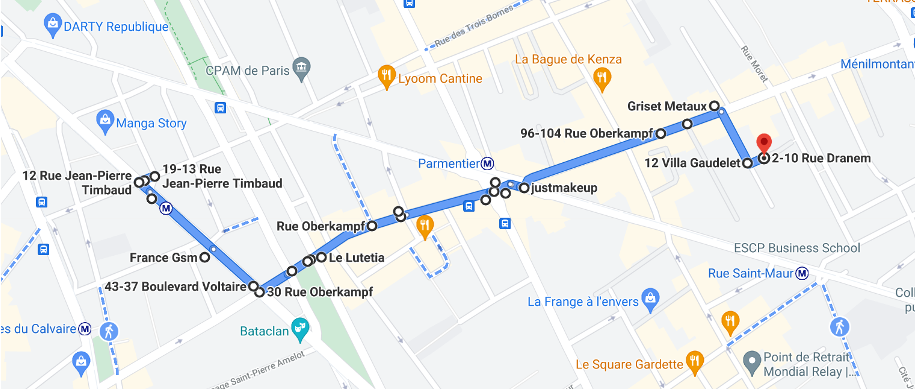

In [82]:
from IPython import display
display.Image("/Users/abdel/Desktop/S12a.png")

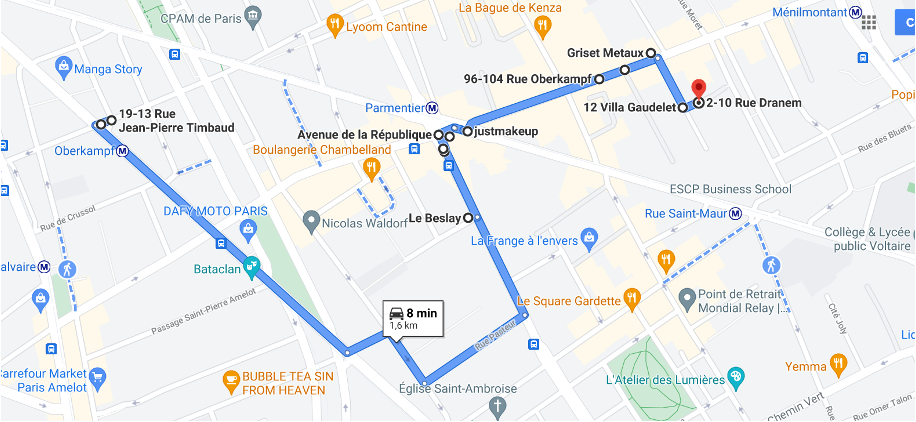

In [83]:
from IPython import display
display.Image("/Users/abdel/Desktop/S12b.png")

In [84]:
def dist(listeofnode):
    diste=0
    a=listeofnode[0]
    b=listeofnode[0]
    for i in listeofnode:
        a,b=b,i
        diste+=distance(graph_node[a],graph_node[b])
    return(diste)